In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import natsort
import shutil
import cv2
import tensorflow as tf
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, BatchNormalization, MaxPool2D, AveragePooling2D
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Tworzenie odpowiednich folerów poprzedzone usunięciem ich w przypadku gdyby już istniały

In [2]:
dirs = ['rps/paper', 'rps/scissors', 'rps/rock']
dirs_test = ['rps-test-set/paper', 'rps-test-set/scissors', 'rps-test-set/rock']
train_size = 1500
test_size = 150


if os.path.exists('test'):
    shutil.rmtree('test', ignore_errors=True)
if os.path.exists('train'):
    shutil.rmtree('train', ignore_errors=True)

if not os.path.exists('test'):
    os.makedirs('test')
if not os.path.exists('train'):
    os.makedirs('train')

## Funkcje służące do tworzenia zbioru do multi-label classification
funkcje łączą ze sobą 2 losowe zdjęcia i zapisują je do odpowiednich folderów, przyjmują parametr num czyli obecny numer zdjęcia, należy je wywołać w pętli tyle razy ile chcemy mieć zdjęć, id nowego zdjęcia jak i jego 'labelki' zapisywane są do listy słowników

In [3]:
train_data_rows = []
test_data_rows = []
def rand_train_img(num):
    rock_lbl, paper_lbl, scissors_lbl = 0, 0, 0
    
    src_dir1 = str('rps/' + str(random.choice(os.listdir('rps'))))
    src_dir2 = str('rps/' + str(random.choice(os.listdir('rps'))))
    
    if 'rock' in src_dir1:
        rock_lbl = 1
    if 'rock' in src_dir2:
        rock_lbl = 1
        
    if 'paper' in src_dir1:
        paper_lbl = 1
    if 'paper' in src_dir2:
        paper_lbl = 1
        
    if 'scissors' in src_dir1:
        scissors_lbl = 1
    if 'scissors' in src_dir2:
        scissors_lbl = 1
    
    #print(src_dir1 +' '+ src_dir2)
    img_name1 = str(src_dir1+ '/' + str(random.choice(os.listdir(src_dir1))))
    img_name2 = str(src_dir2 + '/' + str(random.choice(os.listdir(src_dir2))))
    #print(img_name1 + ' '+ img_name2)
    
    row = {'image_id':'Train_' + str(num)+'.png',
          'rock': rock_lbl,
          'paper': paper_lbl,
          'scissors': scissors_lbl}
    
    #print(row)
    train_data_rows.append(row)
    
    img1 = cv2.imread(img_name1)
    img2 = cv2.imread(img_name2)
    img_final = cv2.hconcat([img1, img2])
    
    filename = str('train/Train_' + str(num)+'.png')
    cv2.imwrite(filename, img_final)
    
    #print(filename)
    
    #plt.imshow(img_final)
    #plt.show()

def rand_test_img(num):
    rock_lbl, paper_lbl, scissors_lbl = 0, 0, 0
    
    src_dir1 = str('rps-test-set/' + str(random.choice(os.listdir('rps-test-set'))))
    src_dir2 = str('rps-test-set/' + str(random.choice(os.listdir('rps-test-set'))))
    
    if 'rock' in src_dir1:
        rock_lbl = 1
    if 'rock' in src_dir2:
        rock_lbl = 1
        
    if 'paper' in src_dir1:
        paper_lbl = 1
    if 'paper' in src_dir2:
        paper_lbl = 1
        
    if 'scissors' in src_dir1:
        scissors_lbl = 1
    if 'scissors' in src_dir2:
        scissors_lbl = 1
    
    #print(src_dir1 +' '+ src_dir2)
    img_name1 = str(src_dir1+ '/' + str(random.choice(os.listdir(src_dir1))))
    img_name2 = str(src_dir2 + '/' + str(random.choice(os.listdir(src_dir2))))
    #print(img_name1 + ' '+ img_name2)
    
    row = {'image_id':'Test_' + str(num)+'.png',
          'rock': rock_lbl,
          'paper': paper_lbl,
          'scissors': scissors_lbl}
    
    #print(row)
    test_data_rows.append(row)
    
    img1 = cv2.imread(img_name1)
    img2 = cv2.imread(img_name2)
    img_final = cv2.hconcat([img1, img2])
    
    filename = str('test/Test_' + str(num)+'.png')
    cv2.imwrite(filename, img_final)
    #print(filename)
    
    #plt.imshow(img_final)
    #plt.show()    

## Tworzenie zbioru
czyli wywołanie funkcji rand_train_img train_size razy aby utworzyć zbiór train oraz rand_test_img test_size razy aby utworzyć zbiór test

In [4]:
for i in range(train_size):
    rand_train_img(i)
for i in range(test_size):
    rand_test_img(i)

zamiana list słowników na DataFramy oraz zapis plików .csv, poprzedony ich usunięciem w razie istnienia

In [5]:
if os.path.exists('train.csv'):
    os.remove('train.csv')
if os.path.exists('test.csv'):
    os.remove('test.csv')

train_data_csv = pd.DataFrame(train_data_rows)
test_data_csv = pd.DataFrame(test_data_rows)
train_data_csv.to_csv('train.csv', index=False)
test_data_csv.to_csv('test.csv', index=False)

Tworzenie danych do treningu, zmiana rozmiaru zdjęć oraz przekonwertowanie ich na grayscale(usunięcie 2 kanałów kolorów) co znacznie zmniejsza rozmiar zdjęcia oraz przyspiesza trenowanie

In [15]:
X = []
for img in natsort.natsorted(os.listdir('train')):
    path = 'train/' + str(img)
    img = image.load_img(path, color_mode = "grayscale", target_size=(300, 300))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)
X = np.array(X)
df = pd.read_csv('train.csv')
y = df.drop(['image_id'], axis = 1)
y = y.to_numpy()

In [16]:
X.shape, y.shape

((1500, 300, 300, 1), (1500, 3))

## Dzielenie danych na dane treningowe oraz testowe oraz budowanie modelu

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [102]:
model = Sequential()
model.add(AveragePooling2D((6, 6), (3,3), input_shape = X_train[0].shape))
model.add(MaxPool2D(2,2))
#model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))
#model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(3, activation='sigmoid'))

Model udało mi się doprowadzić do 80%-towej skuteczności na danych testowych lecz ma on tendencje do overfittingu co można zauważyć na niżej przedstawionych wykresach przebiegu treningu

In [103]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size = 25, validation_data=(X_test, y_test))
print("\nModeel Eval. : \n")
model.evaluate(X_test, y_test)

Epoch 1/15
54/54 [==============================] - 4s 70ms/step - loss: 0.6886 - accuracy: 0.2444 - val_loss: 0.6853 - val_accuracy: 0.1200
Epoch 2/15
54/54 [==============================] - 4s 67ms/step - loss: 0.6711 - accuracy: 0.3622 - val_loss: 0.6173 - val_accuracy: 0.5733
Epoch 3/15
54/54 [==============================] - 4s 68ms/step - loss: 0.4957 - accuracy: 0.6289 - val_loss: 0.3789 - val_accuracy: 0.8400
Epoch 4/15
54/54 [==============================] - 4s 68ms/step - loss: 0.3525 - accuracy: 0.7178 - val_loss: 0.2607 - val_accuracy: 0.8133
Epoch 5/15
54/54 [==============================] - 4s 67ms/step - loss: 0.2610 - accuracy: 0.7459 - val_loss: 0.1649 - val_accuracy: 0.7733
Epoch 6/15
54/54 [==============================] - 4s 68ms/step - loss: 0.2070 - accuracy: 0.7311 - val_loss: 0.1620 - val_accuracy: 0.7733
Epoch 7/15
54/54 [==============================] - 4s 68ms/step - loss: 0.1668 - accuracy: 0.7296 - val_loss: 0.0863 - val_accuracy: 0.7733
Epoch 8/15
54

[0.006493571680039167, 0.8399999737739563]

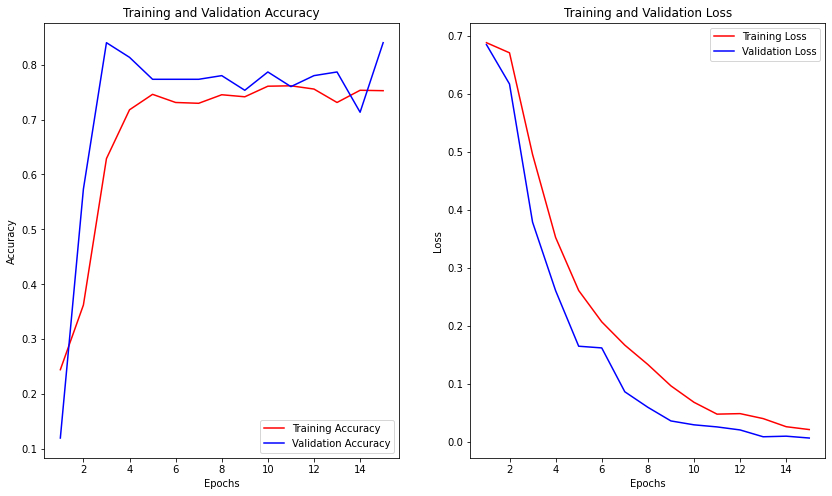

In [104]:
acc_train=history.history['accuracy']
acc_val=history.history['val_accuracy']
loss_train=history.history['loss']
loss_val=history.history['val_loss']

epochs = range(1, 16)
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.plot(epochs,acc_train,'r',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs,loss_train,'r',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Test
przedestowanie modelu dla zdjęcia z folderu testowego, 'labelki' są wyświetlane na bazie tego czy model ma 90% pewność tego ze dane zdjęcie należy do kategorii

scissors
paper


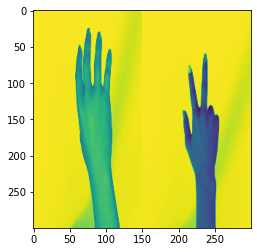

In [180]:
img = image.load_img('test/Test_66.png', color_mode = "grayscale", target_size=(300, 300, 1))
img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)


classes = np.array(df.columns[1:]) 
proba = model.predict(img)  
sorted_categories = np.argsort(proba[0])[:-4:-1]

for i in range(3):
    if proba[0][sorted_categories[i]] >= 0.90:
        print(classes[sorted_categories[i]])

## Wnioski 

Do dalszej poprawy skuteczności modelu można by było zwiększyć zbiór treningowy lub/i wykorzystać Keras Tuner ay znaleźć optymalną architekturę sieci dla danego zbioru